5230 1308 125
5230 1308 125
5230 1308 125
5230 1308 125
5230 1308 125
Accuracy DT: 0.9212538226299694 125 1
F1 DT: 0.8955232414212603 125 1
Accuracy RF: 0.9230886850152904 125 1
F1 RF: 0.8969899474733818 125 1
Accuracy SVC: 0.8755351681957186 125 1
F1 SVC: 0.8213640873679033 125 1
Accuracy MLP: 0.9103975535168196 125 1
F1 MLP: 0.8804155208492954 125 1
2581 646 250
2581 646 250
2581 646 250
2581 646 250
2581 646 250
Accuracy DT: 0.9191950464396286 250 1
F1 DT: 0.8907880492677345 250 1
Accuracy RF: 0.9309597523219815 250 1
F1 RF: 0.9060145523871244 250 1
Accuracy SVC: 0.8925696594427244 250 1
F1 SVC: 0.8556284341433258 250 1
Accuracy MLP: 0.8981424148606812 250 1
F1 MLP: 0.8616294356988922 250 1
1690 423 375
1690 423 375
1690 423 375
1690 423 375
1690 423 375
Accuracy DT: 0.9215130023640663 375 1
F1 DT: 0.8941493841317388 375 1
Accuracy RF: 0.9224586288416077 375 1
F1 RF: 0.8926879291943759 375 1
Accuracy SVC: 0.8898345153664302 375 1
F1 SVC: 0.8451170897496484 375 1
Accuracy MLP: 0.8869

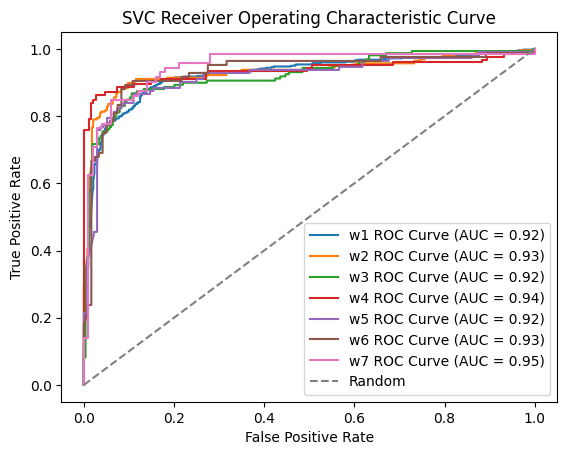

In [4]:
import csv
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew
import numpy as np
import os
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score, f1_score
import math
import scipy.signal as signal
import random
from sklearn.ensemble import RandomForestClassifier
import warnings
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc


warnings.filterwarnings('ignore')

def split_signal_into_windows(data, window_size, labels, threshold):
    windows = []
    windows_labels = []
    num_samples = len(data)
    num_windows = num_samples // window_size
    
    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        #process window
        window = data[start:end]
        windows.append(window)
        #process label
        label_series = labels[start:end]
        anomaly_occurences = label_series.count(1)
        
        #get percentage of anomalous points
        percentage = (anomaly_occurences/window_size) * 100
        #return anomaly if percentage of anomalies is higher than threshold
        #for a 0 threshold, if the window contains one anomalous point, it will be labeled as anomaly.
        #for a 100 threshold, the window is labeled as anomaly only if all points were labeled as anomaly.
        if (percentage > threshold):
            windows_labels.append(1)
        else:
            windows_labels.append(0)

        
        
    return windows, windows_labels

def read_file(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header
        
        data = []
        for row in reader:
            sample = [int(float(value)) for value in row[:]]
            data.append(sample)
    
    return data

def plot_windows(windows):
    num_windows = len(windows)
    
    fig, axes = plt.subplots(num_windows, 1, figsize=(8, 4*num_windows))
    
    for i, window in enumerate(windows):
        axes[i].plot(window)
        axes[i].set_title(f'Window {i+1}')
        axes[i].set_xlabel('Sample')
        axes[i].set_ylabel('Value')
    
    plt.tight_layout()
    plt.show()
    
def normalize_data(data):
    normalized_data = []
    num_channels = len(data[0])

    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in data]
        min_val = min(channel_data)
        max_val = max(channel_data)
        
        normalized_channel = [(val - min_val) / (max_val - min_val) for val in channel_data]
        normalized_data.append(normalized_channel)

    normalized_data = np.transpose(normalized_data)
    return normalized_data

def split_data_and_labels(data):
    num_channels = len(data[0])
    channel_data = [sample[num_channels-1] for sample in data]
    data = [sample[:-1] for sample in data]

    return data, channel_data

def calculate_channel_kurtosis(window):
    num_channels = len(window[0])
    kurtosis_values = []

    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        channel_kurtosis = kurtosis(channel_data)
        if np.isnan(channel_kurtosis):
            channel_kurtosis = 0
        kurtosis_values.append(channel_kurtosis)
        
    return kurtosis_values

def calculate_channel_skewness(window):
    num_channels = len(window[0])
    skew_values = []

    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        channel_skew = skew(channel_data)
        if np.isnan(channel_skew):
            channel_skew = 0
        skew_values.append(channel_skew)
        
    return skew_values


def calculate_channel_rms(window):
    num_channels = len(window[0])
    rms_values = []

    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        rms = np.sqrt(np.mean(np.square(channel_data)))
        if np.isnan(rms):
            rms = 0
        rms_values.append(rms)
        
    return rms_values

def get_channels_peaks(window):
    num_channels = len(window[0])
    channel_peaks = []
    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        peaks, _ = find_peaks(channel_data, distance=125)
        var = np.var(peaks)

        if np.isnan(var):
            var = 0

        channel_peaks.append(var)

    return channel_peaks

def get_zcp(window):
    num_channels = len(window[0])
    channel_peaks = []
    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        mean_subtracted_signal = channel_data - np.mean(channel_data)

        zero_crossings = np.where(np.diff(np.sign(mean_subtracted_signal)))[0]


        channel_peaks.append(len(zero_crossings))

    return channel_peaks

def get_zcp_var(window):
    num_channels = len(window[0])
    channel_peaks = []
    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        mean_subtracted_signal = channel_data - np.mean(channel_data)

        zero_crossings = np.where(np.diff(np.sign(mean_subtracted_signal)))[0]
        
        var = np.var(zero_crossings)
        if np.isnan(var):
            var = 0
        channel_peaks.append(var)

    return channel_peaks

def signal_entropy(window):
    num_channels = len(window[0])
    value_counts = {}
    entropies = []
    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        for value in channel_data:
            if value in value_counts:
                value_counts[value] += 1
            else:
                value_counts[value] = 1
    
        probabilities = [count / len(channel_data) for count in value_counts.values()]
    
        entropy_value = 0
        for p in probabilities:
            entropy_value -= p * math.log2(p)
        entropies.append(entropy_value)
    return entropies

def compute_perfusion_index(window):
    num_channels = len(window[0])
    p_indexes = []
    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        # Perform baseline removal to obtain pulsatile component
        baseline = signal.medfilt(channel_data, kernel_size=301)
        pulsatile_component = channel_data - baseline
    
        # Compute perfusion index as the ratio of pulsatile amplitude to the mean signal amplitude
        perfusion_index = np.max(pulsatile_component) / np.mean(channel_data) * 100
        p_indexes.append(perfusion_index)
    return p_indexes

def estimate_snr(window):
    num_channels = len(window[0])
    snrs = []
    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        signal_power = np.var(channel_data)
    
        # Estimate the noise power using a portion of the signal assumed to be noise-free
        noise_estimate = np.mean(channel_data[:100])  # Assuming the first 100 samples are noise-free
        noise_power = np.var(channel_data - noise_estimate)
    
        snr = 10 * np.log10(signal_power / noise_power)
        if np.isnan(snr):
            snr = 0
        snrs.append(snr)
    return snrs

def compute_mad(window):
    num_channels = len(window[0])
    mads = []
    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        mad = np.median(np.abs(channel_data - np.median(channel_data)))
        mads.append(mad)
    return mads

def compute_var(window):
    num_channels = len(window[0])
    varr = []
    for channel in range(num_channels):
        channel_data = [sample[channel] for sample in window]
        var = np.var(channel_data)
        varr.append(var)
    return varr

folder_path = './test_data'  # Path to the folder containing the files
window_size = [125, 125 * 2, 125 * 3, 125 *4, 125*5, 125*6, 7 * 125]

#channels = [1, 2, 3]
#window_size = [125 * 2]
channels = [1]
# Example usage
all_windows = []
all_labels = []
use_selected_features = False
shufle_input_data = True
plot_tsne = False
average_iterations = 5
selected_features = np.array([True, True, True, False, False, False, False, False, False, True, True, True, False, True, True, True, True, 
                              True, False, True, False, False, False, False, True, False, True, True, False, False])
sc = StandardScaler()

for win_index, window_len in enumerate(window_size):
    for no_of_channels in channels:
        all_windows = []
        all_labels = []
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) and (filename.lower().endswith('.txt') or filename.lower().endswith('.csv')):
            # Read the file
                #print(file_path)
                data = read_file(file_path)
                data, labels = split_data_and_labels(data)
                data = normalize_data(data)
                # Split the signal into windows
                windows, windows_labels = split_signal_into_windows(data, window_len, labels, 0)
                for i, window in enumerate(windows):
                    kurtosis_values = calculate_channel_kurtosis(window)
                    skewness_values = calculate_channel_skewness(window)
                    peaks_no = get_channels_peaks(window)
                    zcp_no = get_zcp(window)
                    zcp_var = get_zcp_var(window)
                    ent = signal_entropy(window)
                    pi = compute_perfusion_index(window)
                    rms = calculate_channel_rms(window)
                    mad = compute_mad(window)
                    var = compute_var(window)
                    features = np.concatenate((kurtosis_values[0:no_of_channels], skewness_values[0:no_of_channels], peaks_no[0:no_of_channels],
                                               zcp_no[0:no_of_channels], zcp_var[0:no_of_channels], ent[0:no_of_channels], pi[0:no_of_channels],
                                               rms[0:no_of_channels], mad[0:no_of_channels], var[0:no_of_channels]))
                    all_windows.append(features)
                    all_labels.append(windows_labels[i])
       
        all_windows = sc.fit_transform(all_windows)

        # Combine the arrays into a list of tuples
        combined = list(zip(all_windows, all_labels))
        # Shuffle the combined list
        accuracy_1 = accuracy_2 = accuracy_3 = accuracy_4 = 0
        f1_1 = f1_2 = f1_3 = f1_4 = 0
        

        for i in range(0,average_iterations):
            if shufle_input_data:
                random.shuffle(combined)
            # Unzip the shuffled list back into separate arrays
            all_windows_sh, all_labels_sh = zip(*combined)
            data_list = list(all_windows_sh)
            new_data = []
            for entry in data_list:
                new_entry = [entry[i] for i in range(0, len(entry)) if selected_features[i] == True]
                new_data.append(new_entry)
            if use_selected_features:
                all_windows_sh = new_data
            X_train, X_test, y_train, y_test = train_test_split(all_windows_sh, all_labels_sh, test_size=0.2)
            print(len(X_train), len(X_test), window_len)
            X_train = list(np.nan_to_num(X_train, nan=0.0))
            X_test = list(np.nan_to_num(X_test, nan=0.0))
            
            classifier = MLPClassifier(hidden_layer_sizes=(30), max_iter=30,activation = 'relu',
                                     solver='adam',random_state=1)
            classifier.fit(X_train, y_train)
            y_pred_4 = classifier.predict(X_test)
            accuracy_4 += accuracy_score(y_test, y_pred_4)
            f1_4 += f1_score(y_test, y_pred_4)
        #plt.plot(classifier.loss_curve_)
        #plt.plot(classifier.validation_scores_)
            svc = SVC(C = 1, gamma = 1, kernel = 'linear', probability=True)
            svc.fit(X_train, y_train)
            y_pred_3 = svc.predict(X_test)
            accuracy_3 += accuracy_score(y_test, y_pred_3)
            f1_3 += f1_score(y_test, y_pred_3)
#
            dt = DecisionTreeClassifier(criterion= 'gini', max_depth=6)
            dt.fit(X_train, y_train)
            y_pred_1 = dt.predict(X_test)
            accuracy_1 += accuracy_score(y_test, y_pred_1)
            f1_1 += f1_score(y_test, y_pred_1)
            
            rf = RandomForestClassifier(max_depth = 5, n_estimators = 15)
            rf.fit(X_train, y_train)
            y_pred_2 = rf.predict(X_test)
            accuracy_2 += accuracy_score(y_test, y_pred_2)
            f1_2 += f1_score(y_test, y_pred_2)
            
            #print(no_of_channels, accuracy_1/(i + 1), accuracy_2/(i + 1), accuracy_3/(i + 1), accuracy_4/(i + 1))
            
        print("Accuracy DT:", accuracy_1/average_iterations, window_len, no_of_channels)
        print("F1 DT:", f1_1/average_iterations, window_len, no_of_channels)
        print("Accuracy RF:", accuracy_2/average_iterations, window_len, no_of_channels)
        print("F1 RF:", f1_2/average_iterations, window_len, no_of_channels)
        print("Accuracy SVC:", accuracy_3/average_iterations, window_len, no_of_channels)
        print("F1 SVC:", f1_3/average_iterations, window_len, no_of_channels)
        print("Accuracy MLP:", accuracy_4/average_iterations, window_len, no_of_channels)
        print("F1 MLP:", f1_4/average_iterations, window_len, no_of_channels)
        data_list = list(all_windows)
        
        models = [dt, rf, svc, classifier]
        y_scores = svc.predict_proba(X_test)[:, 1]
        # Compute the false positive rate (FPR), true positive rate (TPR), and thresholds
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)
        
        # Compute the AUC score
        auc_score = auc(fpr, tpr)
        
        # Plot the ROC curve
        plt.plot(fpr, tpr, label='w{} ROC Curve (AUC = {:.2f})'.format(win_index + 1, auc_score))


        if plot_tsne:
            class_labels = np.array(all_labels_sh)  # Convert to NumPy array if needed
            unique_classes = np.unique(class_labels)  # Get unique class labels
            num_classes = len(windows_labels)
            tsne = TSNE(n_components=3, perplexity=50)
            embedded_data = tsne.fit_transform(np.array(new_data))
        
        
            colors = ['r', 'b']  # Generate a range of colors
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            labels = ['Clean windows', 'Anomalous windows']
            for i, u in enumerate(unique_classes):
                class_data = embedded_data[class_labels == u]
                ax.scatter(class_data[:, 0], class_data[:, 1],  class_data[:, 2], c=colors[i], label=labels[i])
            
            ax.set_xlabel('tSNE-1')
            ax.set_ylabel('tSNE-2')
            ax.set_title('tSNE visualization of extracted features from PPG signals')

            plt.legend()
            plt.show()
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVC Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

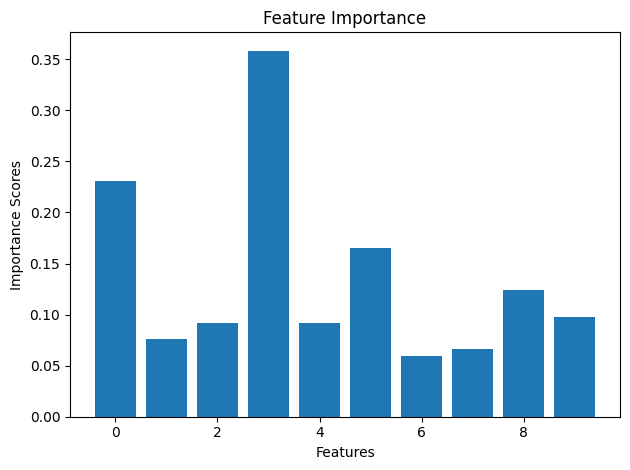

Accuracy: 0.9418604651162791
[0 1 2 3 4 5 6 7 8 9]


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Step 2: Feature Analysis
# Perform statistical analysis on the features (e.g., correlations, distributions)

# Step 3: Feature Selection
# SelectKBest with mutual information as an example
selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 15 features
X_selected = selector.fit_transform(all_windows, all_labels)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Get the corresponding feature names

# Plot the feature importance scores
scores = selector.scores_
plt.bar(range(len(scores)), scores)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Step 4: Cross-Validation
X_train, X_test, y_train, y_test = train_test_split(X_selected, all_labels, test_size=0.2, random_state=42)

# Step 5: Train and Evaluate Classifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(selected_feature_indices)


In [6]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Create an instance of logistic regression
logreg = DecisionTreeClassifier()

# Initialize variables to store the best performance
best_accuracy = 0
best_f1 = 0
best_features = None

# Iterate over different numbers of features
for n in range(1, len(X_train[0])+1):
    # Create an RFE model with logistic regression and specify the number of features to select
    rfe = RFE(estimator=logreg, n_features_to_select=n)

    # Fit the RFE model to your training data
    rfe.fit(X_train, y_train)

    # Access the selected features
    selected_features = rfe.support_

    # Filter the data based on selected features
    new_data = [entry[selected_features] for entry in all_windows_sh]

    # Split the filtered data into training and test sets
    X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(new_data, all_labels_sh, test_size=0.2)
    print(len(X_train_2[0]))
    # Evaluate the performance of the random forest classifier
    accuracy = 0
    f1 = 0
    for _ in range(10):
        rf = DecisionTreeClassifier()
        rf.fit(X_train_2, y_train_2)
        y_pred_2 = rf.predict(X_test_2)
        accuracy += accuracy_score(y_test_2, y_pred_2)
        f1 += f1_score(y_test_2, y_pred_2)

    # Calculate average performance
    accuracy /= 10
    f1 /= 10
    print("Accuracy RF:", accuracy)
    print("F1 RF:", f1)
    # Check if the current performance is better than the previous best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_f1 = f1
        best_features = selected_features

# Print the best performance and selected features
print("Best Accuracy RF:", best_accuracy)
print("Best F1 RF:", best_f1)
print("Best Features:", best_features, len(np.where(best_features)[0]))

1
Accuracy RF: 0.8676470588235292
F1 RF: 0.8402366863905326
2
Accuracy RF: 0.9004901960784313
F1 RF: 0.8823094501949186
3
Accuracy RF: 0.9053921568627452
F1 RF: 0.8776001959043495
4
Accuracy RF: 0.9102941176470589
F1 RF: 0.8907178141216251
5
Accuracy RF: 0.9102941176470589
F1 RF: 0.8691890977657273
6
Accuracy RF: 0.9117647058823529
F1 RF: 0.8653919425048514
7
Accuracy RF: 0.9181372549019609
F1 RF: 0.9030764949016943
8
Accuracy RF: 0.9524509803921569
F1 RF: 0.9430872073439325
9
Accuracy RF: 0.881372549019608
F1 RF: 0.8599438652766638
10
Accuracy RF: 0.8887254901960786
F1 RF: 0.866711018704682
11
Accuracy RF: 0.9210784313725491
F1 RF: 0.9070928607843782
12
Accuracy RF: 0.9323529411764706
F1 RF: 0.9193769143337978
13
Accuracy RF: 0.8799019607843137
F1 RF: 0.8445128853546748
14
Accuracy RF: 0.9147058823529413
F1 RF: 0.9011002756553074
15
Accuracy RF: 0.9019607843137256
F1 RF: 0.8816086411030646
16
Accuracy RF: 0.880392156862745
F1 RF: 0.8391067181780338
17
Accuracy RF: 0.8980392156862745
F

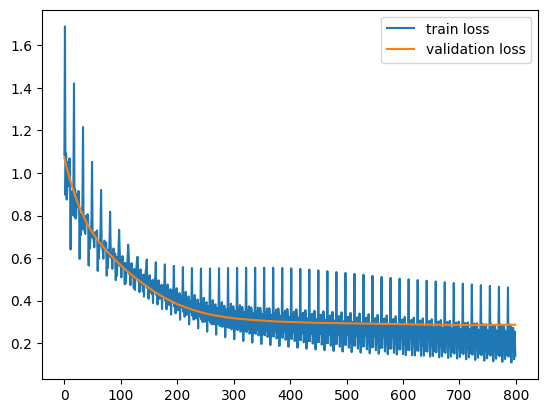

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss


# Initialize
clf = MLPClassifier(hidden_layer_sizes=(10,10), max_iter=100,activation = 'relu',
                    solver='adam',random_state=1, learning_rate_init=1e-3)
batch_size, train_loss_, valid_loss_ = 50, [], []
# Training Loop
for _ in range(50):
    for b in range(batch_size, len(y_train), batch_size):
    
        X_batch, y_batch = X_train[b-batch_size:b], y_train[b-batch_size:b]

        clf.partial_fit(X_batch, y_batch, classes=[0, 1])
        train_loss_.append(clf.loss_)
        valid_loss_.append(log_loss(y_test, clf.predict_proba(X_test)))

plt.plot(range(len(train_loss_)), train_loss_, label="train loss")
plt.plot(range(len(train_loss_)), valid_loss_, label="validation loss")
plt.legend()


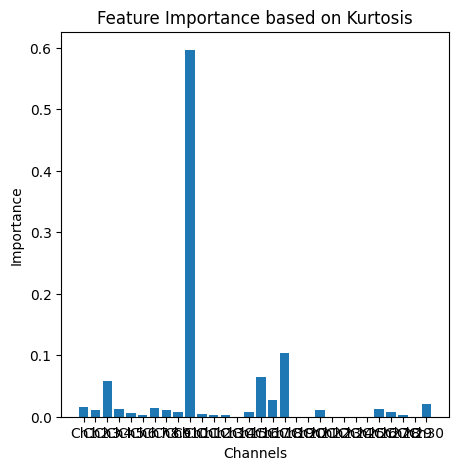

In [8]:
feature_importances = rf.feature_importances_

# Print feature importances
#for i, importance in enumerate(feature_importances):
#    print(f"Channel {(i%3)} Importance: {importance}")
    
channel_labels = [f"Ch{i+1}" for i in range(len(feature_importances))]
plt.figure(figsize=(5, 5))

plt.bar(channel_labels, feature_importances)
plt.xlabel('Channels')
plt.ylabel('Importance')
plt.title('Feature Importance based on Kurtosis')
plt.show()


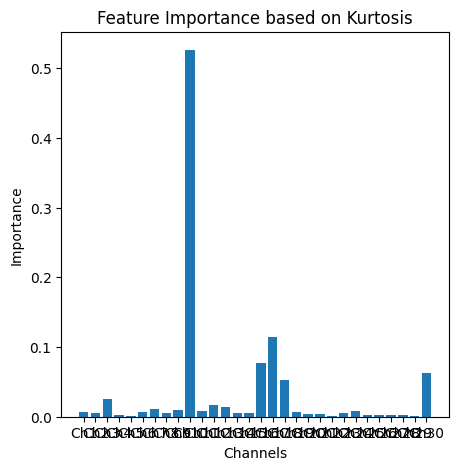

In [9]:
# Train the XGBoost model
model = xgb.XGBRegressor()
model.fit(all_windows, all_labels)

# Get the feature importance scores
importance_scores = model.feature_importances_

# Print the feature importance scores
#for i, score in enumerate(importance_scores):
channel_labels = [f"Ch{i+1}" for i in range(len(importance_scores))]
plt.figure(figsize=(5, 5))

plt.bar(channel_labels, importance_scores)
plt.xlabel('Channels')
plt.ylabel('Importance')
plt.title('Feature Importance based on Kurtosis')
plt.show()

In [10]:
def plotScatterSamples(normal_samples, anomaly_samples, num_samples, title=''):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for i in range(num_samples):
        ax.scatter(normal_samples[i].T[0], normal_samples[i].T[1], normal_samples[i].T[2], c='b')
        ax.scatter(anomaly_samples[i].T[0], anomaly_samples[i].T[1], anomaly_samples[i].T[2], c='r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(title)

In [11]:
indexes = [i for i, x in enumerate(all_labels) if x == 0]
# Convert the tuple to a list
data_list = list(all_windows)
# Index the list using the indexes list
selected_values_normal = [data_list[i] for i in indexes]

indexes = [i for i, x in enumerate(all_labels_sh) if x == 1]
# Index the list using the indexes list
selected_values_abnormal = [data_list[i] for i in indexes]

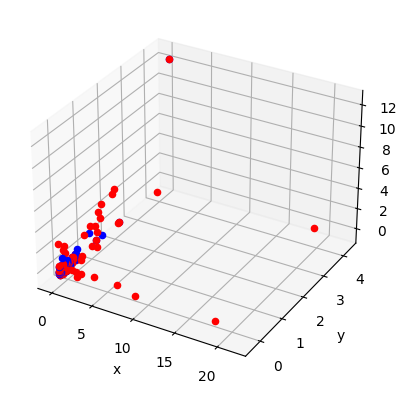

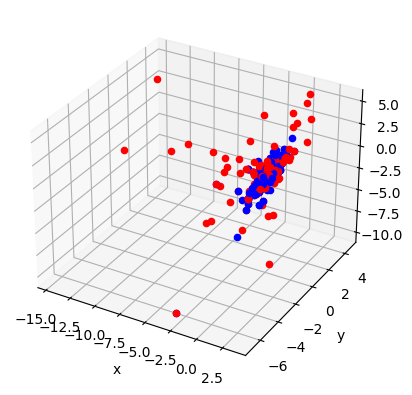

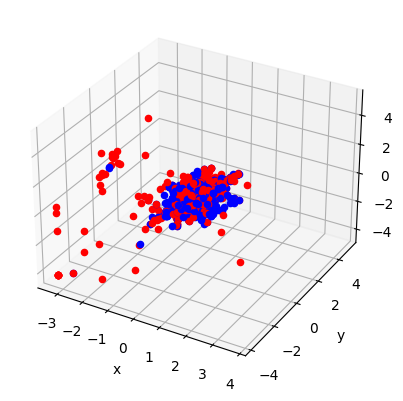

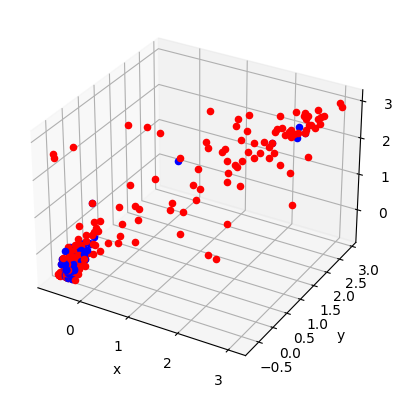

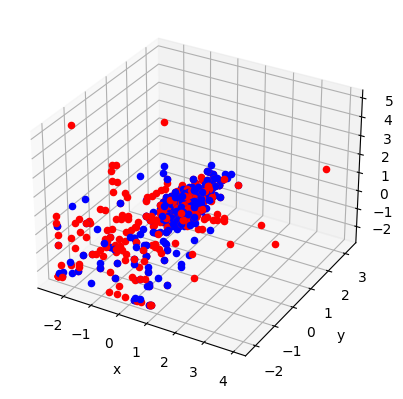

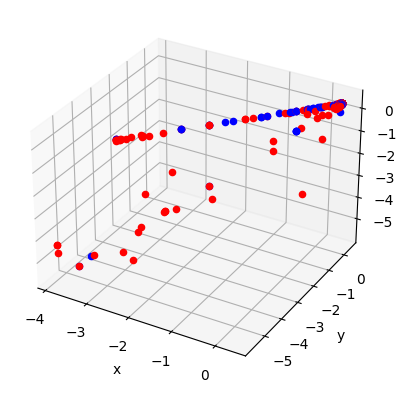

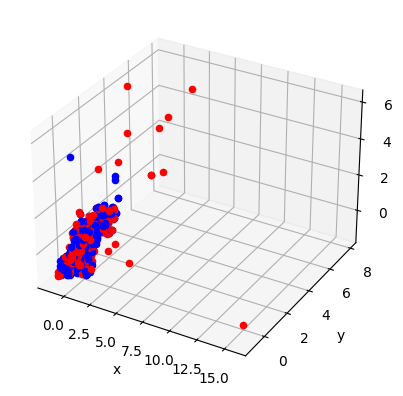

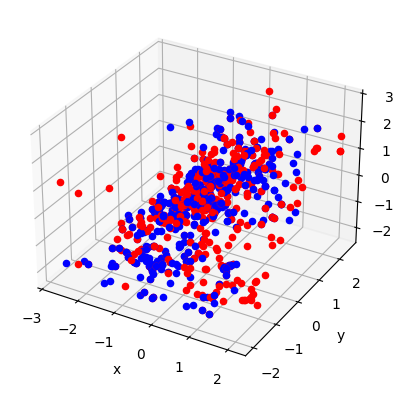

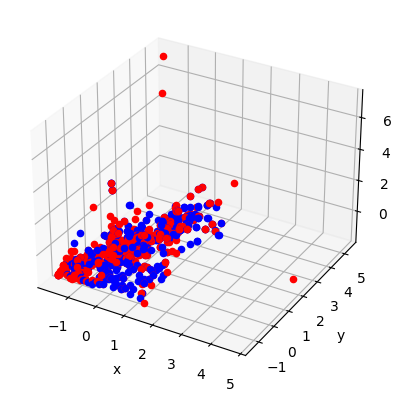

In [12]:
j = 0
for i in range(0, 9):
    plot_normal = [arr[j:j+3] for arr in selected_values_normal]
    plot_abnormal = [arr[j:j+3] for arr in selected_values_abnormal]
    plotScatterSamples(plot_normal, plot_abnormal,len(plot_abnormal))
    j = (i + 1) * 3


In [13]:
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

param_dist = {'n_estimators': [5, 10, 15],
              'max_depth': [1, 2, 3, 4, 5, 6]}
X_train, X_test, y_train, y_test = train_test_split(all_windows_sh, all_labels_sh, test_size=0.3, random_state=42)


# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = GridSearchCV(rf, param_grid = param_dist, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_
y_pred = rand_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, window_len, no_of_channels)
# Print the best hyperparameters
print('RF Best hyperparameters:',  rand_search.best_params_, rand_search.best_score_)

param_dist = {'criterion': ['gini', 'entropy'],
              'max_depth': [1, 2, 3, 4, 5, 6]}

dt = DecisionTreeClassifier()
# Use random search to find the best hyperparameters
rand_search = GridSearchCV(dt, param_grid = param_dist, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_
y_pred = rand_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, window_len, no_of_channels)
# Print the best hyperparameters
print('DT Best hyperparameters:',  rand_search.best_params_, rand_search.best_score_)

param_grid = {'C':[1,10],'gamma':[1,0.1, 0.001], 'kernel':['linear','rbf']}

dt = SVC()
# Use random search to find the best hyperparameters
rand_search = GridSearchCV(dt, param_grid = param_grid, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_
y_pred = rand_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy, window_len, no_of_channels)
# Print the best hyperparameters
print('SVC Best hyperparameters:',  rand_search.best_params_, rand_search.best_score_)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9281045751633987 750 3
RF Best hyperparameters: {'max_depth': 5, 'n_estimators': 10} 0.9297646015955875
Accuracy: 0.8823529411764706 750 3
DT Best hyperparameters: {'criterion': 'gini', 'max_depth': 6} 0.9115039889687777
Accuracy: 0.9052287581699346 750 3
SVC Best hyperparameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} 0.9269575494927608
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       186
           1       0.88      0.88      0.88       120

    accuracy                           0.91       306
   macro avg       0.90      0.90      0.90       306
weighted avg       0.91      0.91      0.91       306

[[172  14]
 [ 15 105]]
